### 任务
赛题以预测二手车的交易价格为任务，数据集报名后可见并可下载，该数据来自某交易平台的二手车交易记录，总数据量超过40w，包含31列变量信息，其中15列为匿名变量。为了保证比赛的公平性，将会从中抽取15万条作为训练集，5万条作为测试集A，5万条作为测试集B，同时会对name、model、brand和regionCode等信息进行脱敏。

### 数据字段表
![title](image/field_table.PNG)

### 评测标准
![title](image/metric.PNG)

In [6]:
# 基础工具包
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display,clear_output
import time

#忽略警告
warnings.filterwarnings("ignore")
#用于画图
%matplotlib inline

#模型预测包，回归模型
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

#数据降维处理
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

#基于GBDT的实现模型
import lightgbm as lgb
import xgboost as xgb

#参数搜索，网格搜索等
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
#评价 均方误差和平均绝对误差
from sklearn.metrics import mean_squared_error,mean_absolute_error

### 数据探索

In [7]:
#读取训练集和测试集A数据,数据集以空格间隔
Train_data=pd.read_csv("Dataset/train_data/used_car_train_20200313.csv",sep=" ")
TestA_data=pd.read_csv("Dataset/test_data/used_car_testA_20200313.csv",sep=" ")

#输出数据规模
print("Train_data shape: ",Train_data.shape)
print("Test_data shape: ",TestA_data.shape)

Train_data shape:  (150000, 31)
Test_data shape:  (50000, 30)


In [8]:
#浏览部分数据,默认前5行数据
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [10]:
#查看字段信息，及缺失值情况
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

可以看出训练集31个字段，共150000条数据，但字段"model","bodyType","fuelType","gearbox"字段有缺失值

In [11]:
#查看列名
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [12]:
#查看测试集A的数据字段信息
TestA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

可以看出测试集含除了"price"字段外，30个字段，共50000条数据，其中字段"bodyType","fuelType","gearbox"字段有缺失值

In [13]:
#查看数值型特征列的统计信息
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [14]:
#查看测试集A的数值型特征列的统计信息
TestA_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,48587.000000,47107.000000,48090.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,174999.500000,68542.223280,2.003393e+07,46.844520,8.056240,1.782185,0.373405,0.224350,119.883620,12.595580,...,0.248669,0.045021,0.122744,0.057997,0.062000,-0.017855,-0.013742,-0.013554,-0.003147,0.001516
std,14433.901067,61052.808133,5.368870e+04,49.469548,7.819477,1.760736,0.546442,0.417158,185.097387,3.908979,...,0.044601,0.051766,0.195972,0.029211,0.035653,3.747985,3.231258,2.515962,1.286597,1.027360
min,150000.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.160049,-5.411964,-8.916949,-4.123333,-6.112667
25%,162499.750000,11203.500000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243762,0.000044,0.062644,0.035084,0.033714,-3.700121,-1.971325,-1.876703,-1.060428,-0.437920
50%,174999.500000,52248.500000,2.003091e+07,29.000000,6.000000,1.000000,0.000000,0.000000,109.000000,15.000000,...,0.257877,0.000815,0.095828,0.057084,0.058764,1.613212,-0.355843,-0.142779,-0.035956,0.138799
75%,187499.250000,118856.500000,2.007110e+07,65.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265328,0.102025,0.125438,0.079077,0.087489,2.832708,1.262914,1.764335,0.941469,0.681163
max,199999.000000,196805.000000,2.015121e+07,246.000000,39.000000,7.000000,6.000000,1.000000,20000.000000,15.000000,...,0.291618,0.153265,1.358813,0.156355,0.214775,12.338872,18.856218,12.950498,5.913273,2.624622


### 特征与标签构建

In [31]:
#提取数值类型特征列名,不包括“object”字段
numerical_cols=Train_data.select_dtypes(exclude=['object']).columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [33]:
#提取“object”类型字段
categorical_cols=Train_data.select_dtypes(include=["object"]).columns
print(categorical_cols)

Index(['notRepairedDamage'], dtype='object')


In [39]:
#选择特征列
feature_cols=[col for col in numerical_cols if col not in ["SaleID","name","regDate","creatDate","price","model","brand","regionCode","seller"]]
print(feature_cols)
print()
#去掉含"Type"的字段列
feature_cols=[col for col in feature_cols if "Type" not in col]
print(feature_cols)

['bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'offerType', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']

['gearbox', 'power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


In [45]:
#提取特征列、标签列构造训练样本
X_data=Train_data[feature_cols]
#训练集标签
Y_data=Train_data["price"] 

#测试样本
X_test=TestA_data[feature_cols]
print("X train shape: ",X_data.shape)
print("X test shape: ",X_test.shape)


X train shape:  (150000, 18)
X test shape:  (50000, 18)


In [42]:
#定义统计函数
def Sta_inf(data):
    print("_min: ",np.min(data))
    print("_max: ",np.max(data))
    print("_mean: ",np.mean(data))
    print("_ptp: ",np.ptp(data))#最大值与最小值的差
    print("_std: ",np.std(data))#标准差
    print("_var: ",np.var(data))#方差

### 统计标签的基本分布信息

In [43]:
print("Sta of label: ")
Sta_inf(Y_data)

Sta of label: 
_min:  11
_max:  99999
_mean:  5923.327333333334
_ptp:  99988
_std:  7501.973469876635
_var:  56279605.942732885


In [47]:
#查看训练集标签数据信息
print(Y_data.describe())

count    150000.000000
mean       5923.327333
std        7501.998477
min          11.000000
25%        1300.000000
50%        3250.000000
75%        7700.000000
max       99999.000000
Name: price, dtype: float64


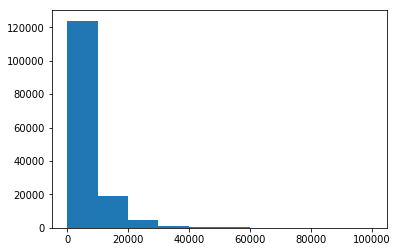

In [46]:
#绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()

### 处理缺失值，用-1填充

In [51]:
X_data=X_data.fillna(-1)
X_test=X_test.fillna(-1)
X_data.info()
print()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 18 columns):
gearbox      150000 non-null float64
power        150000 non-null int64
kilometer    150000 non-null float64
v_0          150000 non-null float64
v_1          150000 non-null float64
v_2          150000 non-null float64
v_3          150000 non-null float64
v_4          150000 non-null float64
v_5          150000 non-null float64
v_6          150000 non-null float64
v_7          150000 non-null float64
v_8          150000 non-null float64
v_9          150000 non-null float64
v_10         150000 non-null float64
v_11         150000 non-null float64
v_12         150000 non-null float64
v_13         150000 non-null float64
v_14         150000 non-null float64
dtypes: float64(17), int64(1)
memory usage: 20.6 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
gearbox      50000 non-null float64
power        50000 non-null

### 模型训练和预测

In [53]:
# xgb构建回归模型
xgr=xgb.XGBRegressor(n_estimators=120,learning_rate=0.1,gamma=0,subsample=0.8,colsample_bytree=0.9,max_depth=7,objective="reg:squarederror")

scores_train=[]
scores=[]

# 5折交叉验证方式(每次都打乱数据)
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
#获取每折交叉验证的训练集数据下标、验证集数据下标
for train_ind,val_ind in sk.split(X_data,Y_data):
    #训练集数据
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    #验证集数据
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    #拟合回归模型
    xgr.fit(train_x,train_y)
    
    #对训练集预测
    pred_train_xgb=xgr.predict(train_x)
    #对预测集预测
    pred_xgb=xgr.predict(val_x)
    
    #平均绝对误差
    score_train=mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score=mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

#训练集的5折交叉验证的mae
print("Train mae: ",np.mean(scores_train))
#验证集的5折交叉验证的mae
print("Val mae: ",np.mean(scores))

Train mae:  622.733267782118
Val mae:  716.9413046839576


### 定义xgb、lgb模型函数

In [63]:
def build_model_xgb(x_train,y_train):
    model=xgb.XGBRegressor(n_estimators=150,learning_rate=0.1,gamma=0,subsample=0.8,colsample_bytree=0.9,max_depth=7,objective="reg:squarederror")
    #拟合模型
    model.fit(x_train,y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator=lgb.LGBMRegressor(num_leaves=127,n_estimators=1970,max_depth=13,early_stopping_round=50,metric=['l1'])
    
    param_grid={
        "learning_rate":[0.01,0.05,0.1,0.2]
    }
    #网格调参
    gbm=GridSearchCV(estimator,param_grid)
    gbm.fit(x_train,y_train,eval_metric="l1")
    return gbm

### 切分数据集进行模型训练、评价、预测

In [64]:
#训练集占0.7，验证集占0.3
x_train,x_val,y_train,y_val=train_test_split(X_data,Y_data,test_size=0.3)

In [65]:
#将训练集分为训练集和验证集训练
print("Train lgb......")
model_lgb=build_model_lgb(x_train,y_train)
val_lgb=model_lgb.predict(x_val)
MAE_lgb=mean_absolute_error(y_val,val_lgb)
print("MAE of val with lgb: ",MAE_lgb)

#将整个训练集用于训练,对测试集进行预测
print("Predict lgb......")
model_lgb_pre=build_model_lgb(X_data,Y_data)
subA_lgb=model_lgb_pre.predict(X_test)
print("Sta of Predict lgb: ")
Sta_inf(subA_lgb)

Train lgb......
MAE of val with lgb:  677.7556019979628
Predict lgb......
Sta of Predict lgb: 
_min:  -570.3990108402187
_max:  89924.042552498
_mean:  5926.783605327253
_ptp:  90494.44156333822
_std:  7393.169739105736
_var:  54658958.79122877


In [60]:
print("Train xgb......")
model_xgb=build_model_xgb(x_train,y_train)
val_xgb=model_xgb.predict(x_val)
MAE_xgb=mean_absolute_error(val_xgb,y_val)
print("MAE of val with xgb: ",MAE_xgb)

print("Predict xgb......")
#使用训练集所有的数据
model_xgb_pre=build_model_xgb(X_data,Y_data)
subA_xgb=model_xgb_pre.predict(X_test)
print("Std of Predict xgb: ")
Sta_inf(subA_xgb)

Train xgb......
MAE of val with xgb:  714.9782204981831
Predict xgb......
Std of Predict xgb: 
_min:  -206.51274
_max:  89728.52
_mean:  5923.0776
_ptp:  89935.04
_std:  7359.793
_var:  54166550.0


### 模型融合

MAE of val with Weighted ensemble:  3313.504074227399


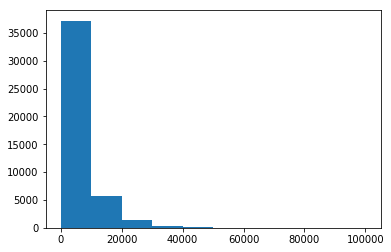

In [77]:
#简单加权融合
val_Weighted=(1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
#对预测"price"值为负数的进行修正
val_Weighted[val_Weighted<0]=5923
print("MAE of val with Weighted ensemble: ",mean_absolute_error(y_val,val_Weighted))
plt.hist(y_val)
plt.show()
plt.close()

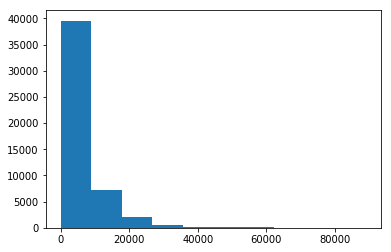

In [80]:
sub_Weighted=(1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb
sub_Weighted[sub_Weighted<0]=5923

#查看预测值的统计
plt.hist(sub_Weighted)
plt.show()
plt.close()


### 输出结果

In [86]:
sub=pd.DataFrame()
sub["SaleID"]=TestA_data.SaleID
sub["price"]=sub_Weighted
print(sub.info())
print()
print(sub.describe())
sub.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
SaleID    50000 non-null int64
price     50000 non-null float64
dtypes: float64(1), int64(1)
memory usage: 781.3 KB
None

              SaleID         price
count   50000.000000  50000.000000
mean   174999.500000   5926.173214
std     14433.901067   7370.642655
min    150000.000000      2.506471
25%    162499.750000   1401.735159
50%    174999.500000   3266.982635
75%    187499.250000   7700.952824
max    199999.000000  88924.774132


,SaleID,price
0,150000,38499.839742
1,150001,367.423182
2,150002,7417.073551
3,150003,11837.854978
4,150004,597.993483
5,150005,1789.982031
6,150006,4534.720513
7,150007,9924.109541
8,150008,3292.338632
9,150009,2170.573149


In [ ]:
sub.to_csv("Dataset/result/sub.csv",index=False)